# Data Cleaning 

#### Alvee Hoque 08-12-21

Found a new data source with all game logs, stats, etc from [GridironAI]('gridironai.com') and will be cleaning the data for features needed for ML Model. I won't be uploading the gridiron modeling data however I have my subset for only the fantasy data that will be accessible. There is another notebook in this repo that goes over scraping data from [ProFootball Reference]('https://www.pro-football-reference.com/'). 

In [1]:
# Imports
import pandas as pd
import seaborn as sns

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Task: Predictions for Each Game 
    1. Get all qbs / rbs / wr / te 
    2. get fantasy points per week for qbs (do without playoffs)
    3. create new dataframe with name + game_num and fantasy points for that game 
        - create a convention ie. Player game1_2020, game2_2020, etc. 

Task: Prediction for Season
    1. get all qbs 
    2. get fantasy points per week per qb. 
    3. forecast season total



In [3]:
# read data 
df = pd.read_csv('gridironai/player_data_2020.csv')

In [4]:
qb = df[(df.position_id == 'QB') & (df.playoffs == 0)]
rb = df[(df.position_id == 'RB') & (df.playoffs == 0)]
wr = df[(df.position_id == 'WR') & (df.playoffs == 0)]
te = df[(df.position_id == 'TE') & (df.playoffs == 0)]

In [5]:
qb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 27 to 23098
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   player_id                          641 non-null    int64  
 1   franchise_id                       641 non-null    object 
 2   position_id                        641 non-null    object 
 3   name                               641 non-null    object 
 4   NFL_draft_year                     579 non-null    float64
 5   NFL_draft_round                    579 non-null    float64
 6   NFL_draft_rank                     579 non-null    float64
 7   height_inches                      638 non-null    float64
 8   weight_pounds                      638 non-null    float64
 9   birthdate                          641 non-null    object 
 10  forty_yd                           511 non-null    float64
 11  three_cone                         411 non-null    floa

In [6]:
qb_cols = ['player_id', 'franchise_id', 'position_id', 'name', 'season', 'week', 
           'passing_yds', 'passing_td', 'passing_int','rushing_yds', 'rushing_td', 'fumbles_lost']

qb = qb[qb_cols]

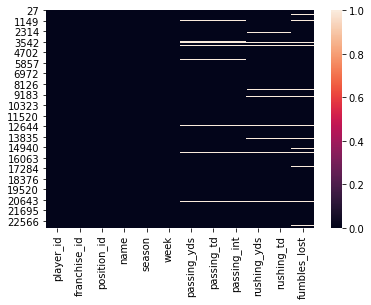

In [7]:
# checking for null values, if null, most likely can fill with 0's for simplicity
sns.heatmap(qb.isnull())

In [8]:
qb.fillna(value=0, inplace=True)

In [9]:
# Fantasy HalfPPR
qb['HalfPPR'] = (qb.passing_yds/25 + qb.passing_td*4 - qb.passing_int*2 + qb.rushing_yds/10 + qb.rushing_td*6 - qb.fumbles_lost*2)

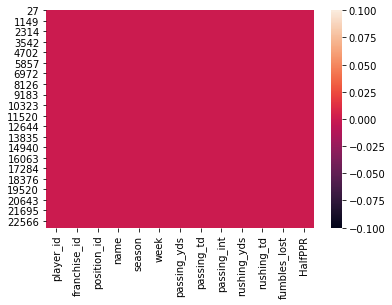

In [10]:
sns.heatmap(qb.isnull())

This data looks good to go. Will create the csv files below

## Create CSV Files

In [95]:
# columns of interest
cols = ['player_id', 'franchise_id', 'position_id', 'name', 'season', 'week', 'playoffs', 
        'passing_yds', 'passing_td', 'passing_int','rushing_yds', 'rushing_td', 
        'receiving_rec', 'receiving_yds', 'receiving_td', 'fumbles_lost']

In [128]:
for year in range(2000,2021):
    # read file 
    df = pd.read_csv(f'gridironai/player_data_{year}.csv', usecols=cols)
    
    # skip playoff stats
    df = df[df.playoffs == 0]
    
    # fill missing values with 0 
    df.fillna(value=0,inplace=True)
    
    
    df['HalfPPR'] = df.passing_yds/25 + df.passing_td*4 - df.passing_int*2 + df.rushing_yds/10 + df.rushing_td*6 - df.fumbles_lost*2 + df.receiving_rec*0.5 +df.receiving_yds/10 +df.receiving_td*6

    
    #individual df per position
    qb = df[df.position_id == 'QB']
    rb = df[df.position_id == 'RB']
    wr = df[df.position_id == 'WR']
    te = df[df.position_id == 'TE']
    
    if year == 2000: 
    
        final_qb = qb.groupby(['name','week'])['HalfPPR'].mean().unstack()
        final_rb = rb.groupby(['name','week'])['HalfPPR'].mean().unstack()
        final_wr = wr.groupby(['name','week'])['HalfPPR'].mean().unstack()
        final_te = te.groupby(['name','week'])['HalfPPR'].mean().unstack()

        final_qb = final_qb.add_prefix(f'{year}_game')
        final_rb = final_rb.add_prefix(f'{year}_game')
        final_wr = final_wr.add_prefix(f'{year}_game')
        final_te = final_te.add_prefix(f'{year}_game')
        
        
    else: 
        
        temp1_qb = qb.groupby(['name','week'])['HalfPPR'].mean().unstack()
        temp1_rb = rb.groupby(['name','week'])['HalfPPR'].mean().unstack()
        temp1_wr = wr.groupby(['name','week'])['HalfPPR'].mean().unstack()
        temp1_te = te.groupby(['name','week'])['HalfPPR'].mean().unstack()

        temp1_qb = temp1_qb.add_prefix(f'{year}_game')
        temp1_rb = temp1_rb.add_prefix(f'{year}_game')
        temp1_wr = temp1_wr.add_prefix(f'{year}_game')
        temp1_te = temp1_te.add_prefix(f'{year}_game')
             
        
    if year > 2000: 
        final_qb = pd.concat([final_qb,temp1_qb],axis=1) 
        final_rb = pd.concat([final_rb,temp1_rb],axis=1) 
        final_wr = pd.concat([final_wr,temp1_wr],axis=1) 
        final_te = pd.concat([final_te,temp1_te],axis=1) 
    
final_qb.sort_index(inplace=True)
final_rb.sort_index(inplace=True)
final_wr.sort_index(inplace=True)
final_te.sort_index(inplace=True)

In [130]:
final_qb.to_csv('qb_fantasy.csv')
final_rb.to_csv('rb_fantasy.csv')
final_wr.to_csv('wr_fantasy.csv')
final_te.to_csv('te_fantasy.csv')